# G04. 이미지 어디까지 우려볼까?

# 0. 라이브러리 import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Augmentation 데이터셋 준비 
---
- 두가지 방법을 사용할 것이다.
1. CutMix
2. Mixup (시간이 남는 다면 시도)  
<br>  
- CutMix가 Mixup보다 성능이 좋기 때문에 CutMix를 먼저 시도
    ![image](https://user-images.githubusercontent.com/48716219/96831035-4bc81680-1477-11eb-9132-b95848c002c3.png)


## 1-1) CutMix란?
---
- [논문링크](https://arxiv.org/pdf/1905.04899.pdf)
- 간단하게 데이터를 자르고 섞는다.
- 위에 사진처럼 사진데이터를 잘라서 섞고 라벨에 대한 값 또한 전체사진에 차지하는 비율만큼 라벨을 새로 만들어 준다.

## 1-2) 데이터셋 불러오기

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


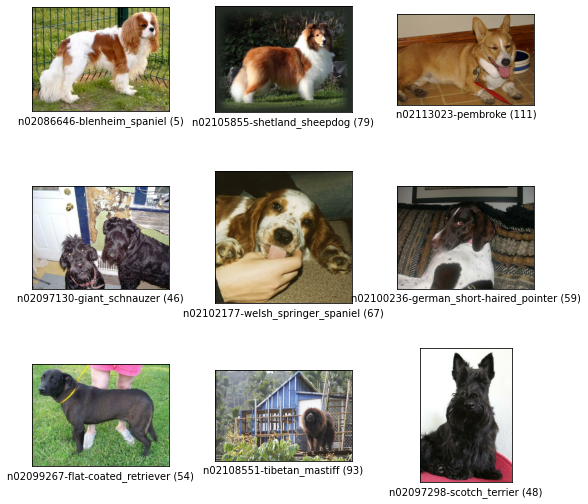

In [4]:
fig = tfds.show_examples(ds_info, ds_train)

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

## 1-3) 이미지 섞기

#### 두개의 이미지 선택

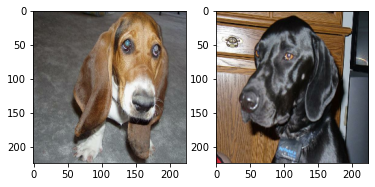

In [8]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

#### a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수

In [9]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [10]:
xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(14, shape=(), dtype=int32) tf.Tensor(106, shape=(), dtype=int32) tf.Tensor(184, shape=(), dtype=int32)


#### 위에서 추출한 bouding box의 점을 가지고 이미지를 섞는다

In [11]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

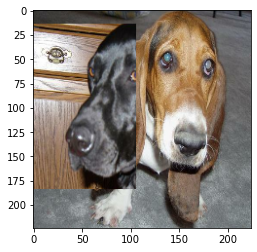

In [12]:
mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

## 1-3) 라벨 섞기
---
- 이미지를 섞었다면 라벨도 이에 맞춰서 섞어줘야한다
- 면적에 비례해서 라벨을 섞어야 한다
- 섞인 이미지의 전체 이미지 비율을 계산해서 두 가지 라벨의 비율로 더해준다

In [13]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label



In [14]:
mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.64086413, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.35913584,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

## 1-4) ```cutmix()``` 함수 구현
- 위에서 구현한 두 함수, ```mix_2_images()```, ```mix_2_label()```를 활용해서 배치단위의 함수 선언

```python
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        image_b = image[tf.cast(tf.random.uniform([],0, batch_size),tf.int32)]
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_label = tf.reshape(tf.stack(mixed_label),(batch_size, num_classes))
    return mixed_imgs, mixed_label
```

In [15]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

## 1-5) 수정된 ```apply_normalize_on_dataset()```
---
- CutMix는 ```batch()``` 함수 뒤에 오도록 만들어야 한다.
    - CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 한다.

In [16]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_crop(image, [224, 224, 3])
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=0.5)
    return image,label

def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
#     label = tf.reshape(tf.stack(label),(batch_size, num_classes))
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [17]:
num_classes = ds_info.features["label"].num_classes

In [18]:
apply_normalize_on_dataset(ds_train, batch_size=16, with_aug=False, with_cutmix=True)

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

#### 평가문항/상세기준

1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?  
CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.


2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?  
Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함


3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?  
기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

## 회고 및 고찰
